# Brain Tumor MRI Dataset - Exploratory Data Analysis

**Author:** Zep Khechadoorian  
**Date:** November 2025  
**Dataset:** [Brain Tumor Classification MRI - Kaggle](https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri)

## 🎯 Objective
Comprehensive exploratory analysis to:
- Understand dataset structure and class balance
- Assess image quality and consistency  
- Identify preprocessing requirements
- Detect data quality issues

## 📊 Quick Stats
- **Total Images:** 3,264
- **Classes:** 4 (3 tumor types + healthy)
- **Image Sizes:** 100px to 1400px (requires standardization)
- **Format:** Pseudo-RGB (3 identical channels)

## Dataset Download and Structure

In [1]:
import os, cv2
import matplotlib.pyplot as plt
import zipfile, gdown
import kagglehub
import shutil
import numpy as np

/Users/zepyoorkhechadoorian/Documents/projects/mri-brain-tumor/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download latest version to kaggle cache
path = kagglehub.dataset_download("sartajbhuvaji/brain-tumor-classification-mri")

print("Path to dataset files:", path)

# Create data directory if it doesn't exist
data_dir = "../data/"
os.makedirs(data_dir, exist_ok=True)

# delete existing dataset directory if it exists
existing_dataset_path = os.path.join(data_dir, "brain_tumor_dataset")
if os.path.exists(existing_dataset_path):
    shutil.rmtree(existing_dataset_path)

# Copy the downloaded dataset to data directory
destination = os.path.join(data_dir, "brain_tumor_dataset")
if os.path.exists(destination):
    shutil.rmtree(destination)  # Remove if already exists
shutil.copytree(path, destination)

print(f"Dataset copied to: {destination}")

Path to dataset files: /Users/zepyoorkhechadoorian/.cache/kagglehub/datasets/sartajbhuvaji/brain-tumor-classification-mri/versions/3
Dataset copied to: ../data/brain_tumor_dataset


We'll start by printing a list of the folders and files in the dataset to get an idea of its structure.

In [3]:
# Explore the downloaded dataset structure
dataset_path = "../data/brain_tumor_dataset"
print("Dataset structure:")
for root, dirs, files in os.walk(dataset_path):
    level = root.replace(dataset_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for file in files[:5]:  # Show first 5 files in each directory
        print(f"{subindent}{file}")
    if len(files) > 5:
        print(f"{subindent}... and {len(files) - 5} more files")

Dataset structure:
brain_tumor_dataset/
  Training/
    no_tumor/
      image(115).jpg
      image(142).jpg
      image(49).jpg
      image(1).jpg
      image(284).jpg
      ... and 390 more files
    meningioma_tumor/
      m1(69).jpg
      m3 (126).jpg
      m3 (62).jpg
      m2 (62).jpg
      m1(86).jpg
      ... and 817 more files
    glioma_tumor/
      gg (362).jpg
      gg (698).jpg
      gg (732).jpg
      gg (227).jpg
      gg (677).jpg
      ... and 821 more files
    pituitary_tumor/
      p (477).jpg
      p (162).jpg
      p (498).jpg
      p (532).jpg
      p (75).jpg
      ... and 822 more files
  Testing/
    no_tumor/
      image(49).jpg
      image(1).jpg
      image(103).jpg
      image(73).jpg
      image(24).jpg
      ... and 100 more files
    meningioma_tumor/
      image(49).jpg
      image(1).jpg
      image(73).jpg
      image(24).jpg
      image(32).jpg
      ... and 110 more files
    glioma_tumor/
      image(49).jpg
      image(1).jpg
      image(73).jpg
 

This shows that our data is split between training and testing already. Within each category, there is a 'no_tumor' folder that contains images of healthy brains, and three other foldrs that contain images of brains with tumors, broken down by type of tumor. Let's take a peak at a couple of examples from each category in the training dataset to see if we can see the differences by eye.

## Visual Exploration

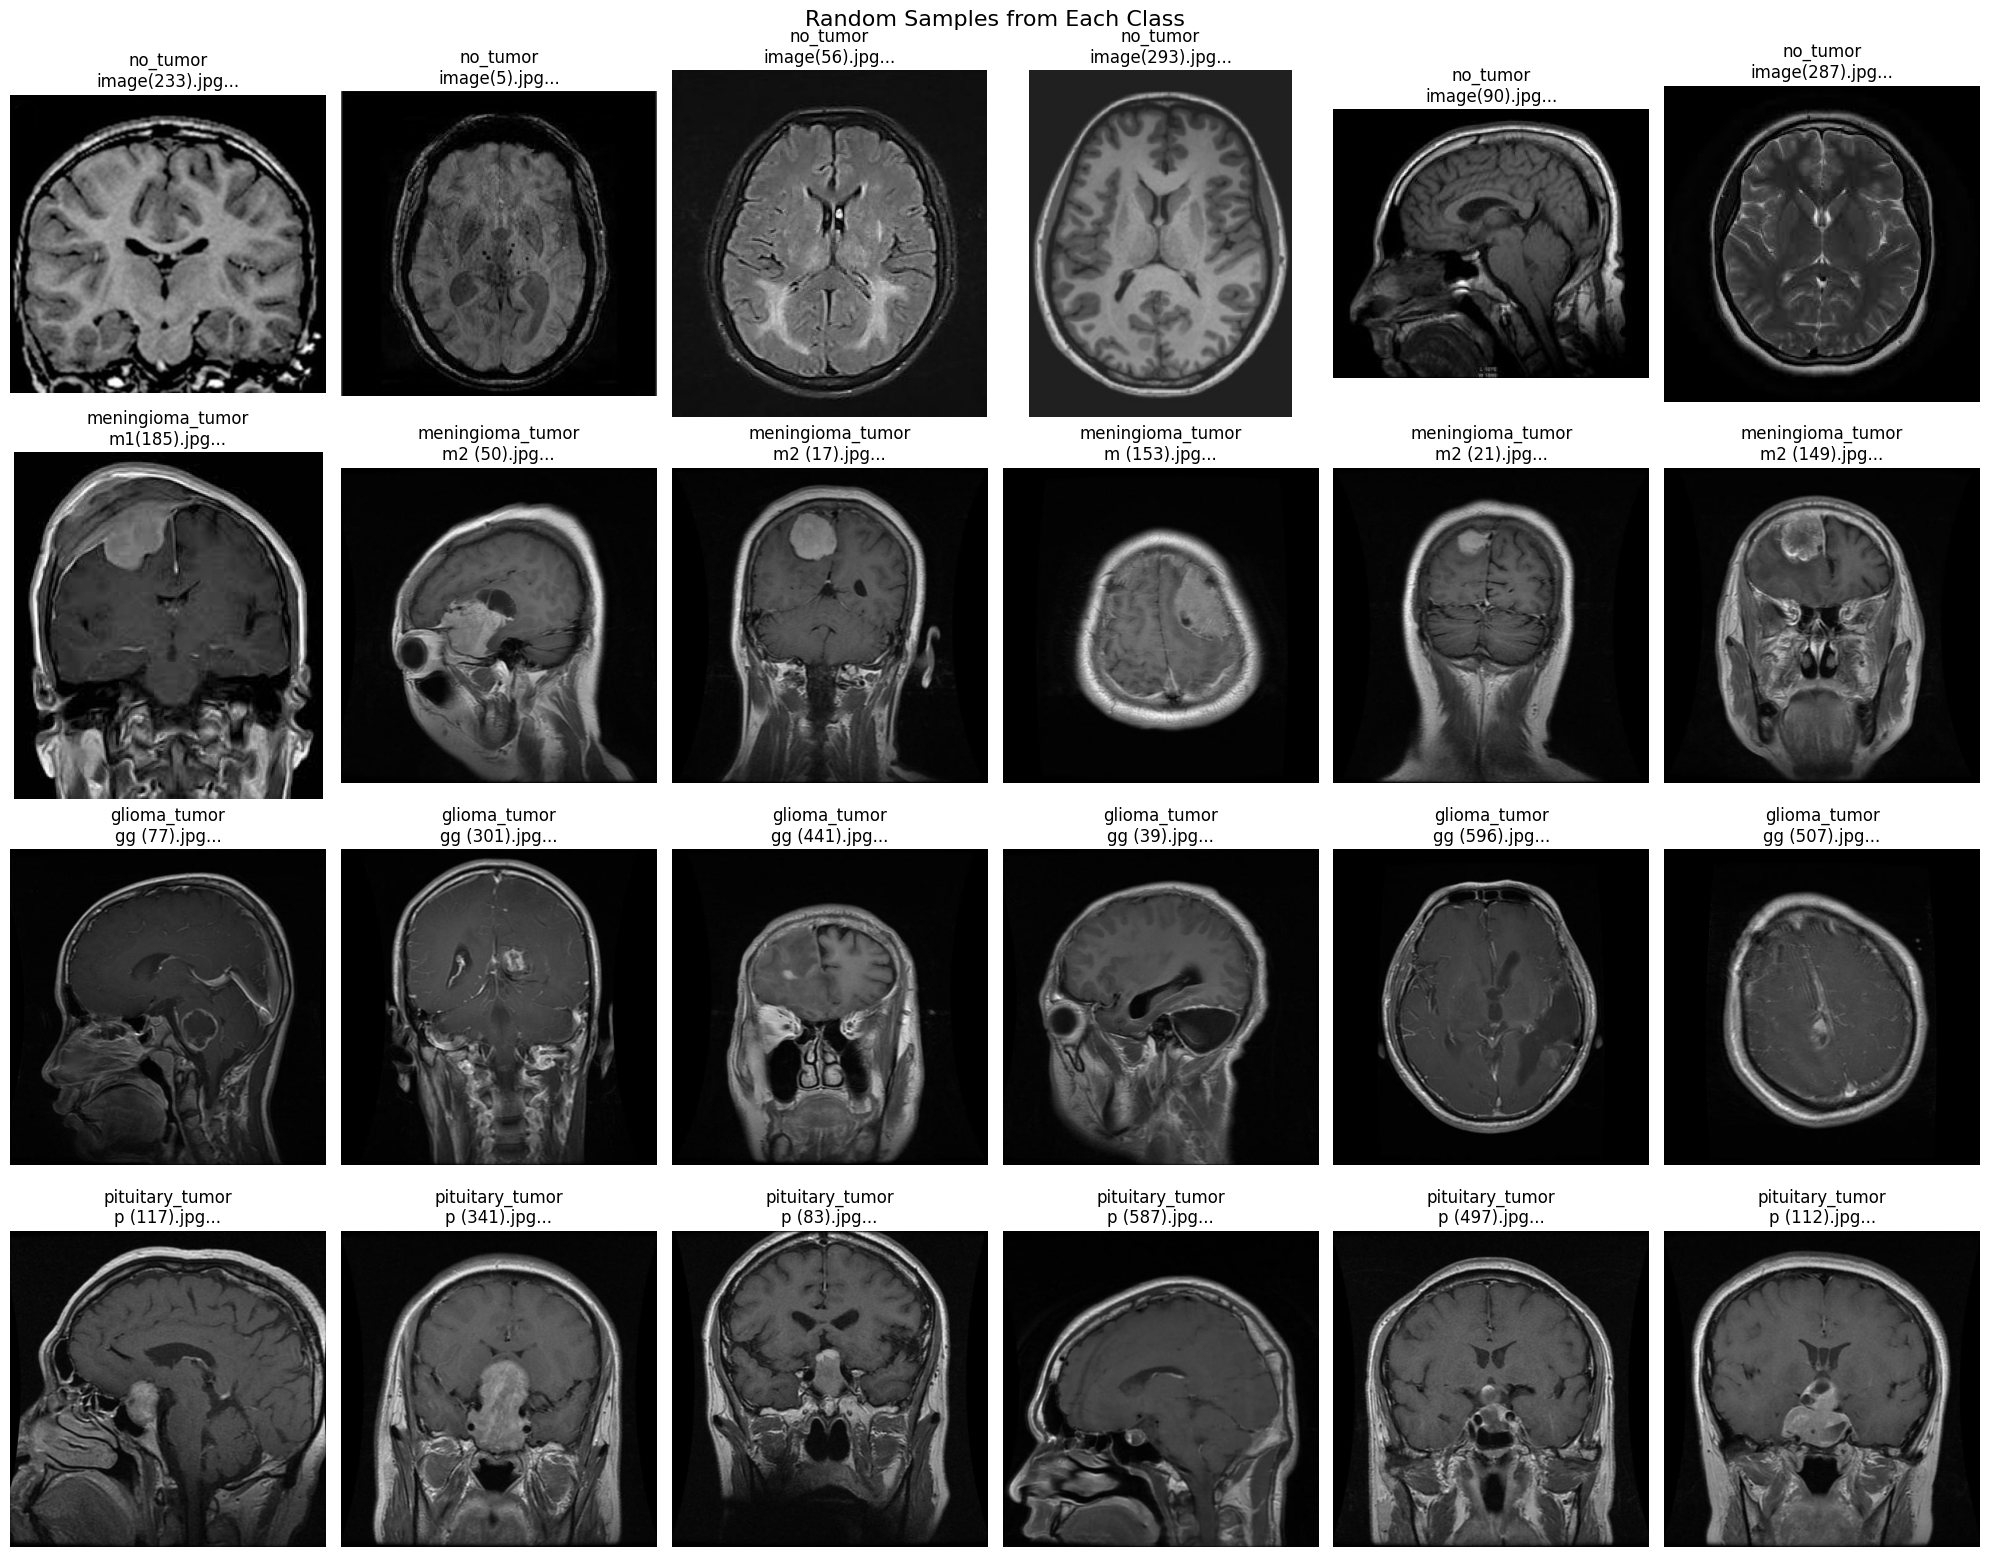

In [4]:
# Get list of classes
classes = os.listdir(os.path.join(dataset_path, "Training"))

# Random Sample Grid Visualization
def show_random_samples(samples_per_class=6):
    fig, axes = plt.subplots(len(classes), samples_per_class, figsize=(20, 4 * len(classes)))
    
    for i, cls in enumerate(classes):
        class_dir = os.path.join("../data/brain_tumor_dataset/Training", cls)
        images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        # Randomly sample images
        random_images = np.random.choice(images, min(samples_per_class, len(images)), replace=False)
        
        for j, img_name in enumerate(random_images):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                axes[i, j].imshow(img)
                axes[i, j].set_title(f"{cls}\n{img_name[:20]}...")
                axes[i, j].axis('off')
    
    plt.suptitle('Random Samples from Each Class', fontsize=16)
    plt.tight_layout()
    plt.show()

show_random_samples()

As fascinating as I find the brain, I am far from being an expert on it. The differences between no tumor and meningioma tumor are bleak.  The same is true for glioma. Personally, I am not sure I can point out tumors in the pituitary gland. Nonetheless, I think it's useful to just look up a quick labeled picture of the different parts of the brain. Also, it's interesting to note that the angle of the images varies--some are aerial MRI images, while others are taking from the front/back/sides.

![Alt text](https://files.miamineurosciencecenter.com/media/filer_public_thumbnails/filer_public/f1/f7/f1f7a2b1-1599-44c7-84a4-54510a6bf308/brain_tumor_locations.jpg__800x494_q85_subject_location-578%2C484_subsampling-2.jpg "")

With a basic understanding of the dataset structure and its contents, I want to find out more about its stats--how many images it has, what the balance is between the different classes, what the images sizes are, etc. It looks like we have monochrome images but not all images are exactly the same size. 

## Class Distribution

Dataset Statistics:
Dataset           Testing  Training
Class                              
glioma_tumor          100       826
meningioma_tumor      115       822
no_tumor              105       395
pituitary_tumor        74       827


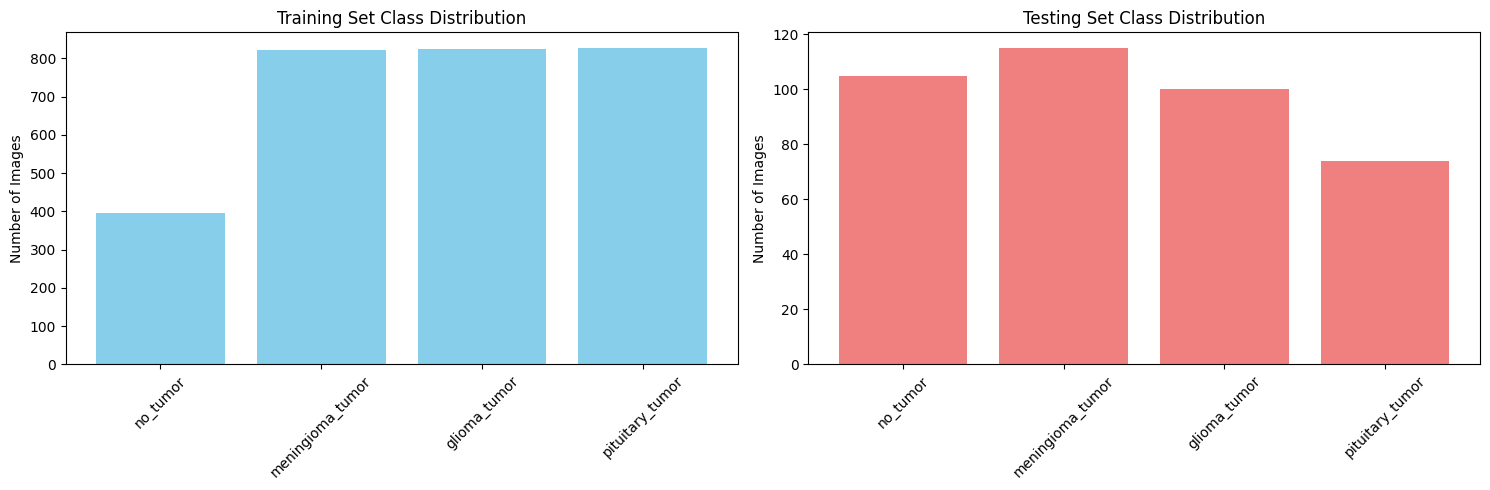

In [5]:
# 1. Dataset Statistics and Class Distribution
import numpy as np
import pandas as pd
from collections import Counter

# Collect dataset statistics
stats = []
for dataset_type in ["Training", "Testing"]:
    dataset_path = os.path.join("../data/brain_tumor_dataset", dataset_type)
    for cls in classes:
        class_dir = os.path.join(dataset_path, cls)
        num_images = len([f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))])
        stats.append({'Dataset': dataset_type, 'Class': cls, 'Count': num_images})

df_stats = pd.DataFrame(stats) # Create DataFrame from stats
print("Dataset Statistics:")
print(df_stats.pivot(index='Class', columns='Dataset', values='Count'))

# Visualize class distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Training set distribution
train_counts = df_stats[df_stats['Dataset'] == 'Training']
ax1.bar(train_counts['Class'], train_counts['Count'], color='skyblue')
ax1.set_title('Training Set Class Distribution')
ax1.set_ylabel('Number of Images')
ax1.tick_params(axis='x', rotation=45)

# Testing set distribution
test_counts = df_stats[df_stats['Dataset'] == 'Testing']
ax2.bar(test_counts['Class'], test_counts['Count'], color='lightcoral')
ax2.set_title('Testing Set Class Distribution')
ax2.set_ylabel('Number of Images')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

The test dataset is roughly evenly distributed (the pituitary class could use a few more samples for better balance) while the test dataset has fewer examples of the healthy MRIs. My initial thoughts on this are that this kind of balance is not the worst in a tumor classification dataset--false positives are worse than false negatives. In other words, I care more that my model can recognize tumored brains better than healthy brains, since missing a diagnosis can be detrimental. I'd be more concerned if we had a lot of healthy brain images, and a small subset of tumored brains.

## Image Dimensions

Image Dimension Statistics:
Height - Min: 167, Max: 1446, Mean: 456.3
Width - Min: 174, Max: 1375, Mean: 452.9
Channels - Min: 3, Max: 3, Mean: 3.0
Unique dimensions: 426


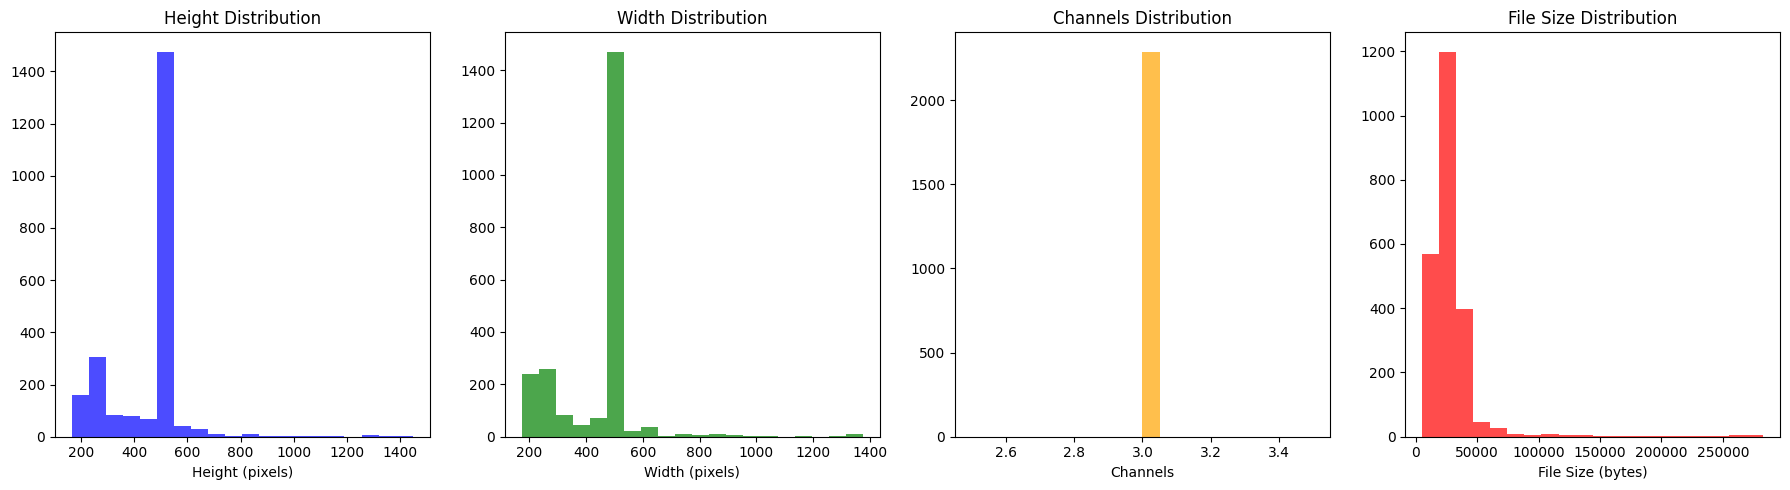

In [6]:
# Image Size Analysis
def analyze_image_dimensions():
    """Analyze and visualize image dimensions in the dataset.
    Inputs:         None (uses predefined dataset path)
    Outputs:        DataFrame with image dimensions statistics (Height, Width, Channels)
    """
    dimensions = []
    file_sizes = []
    
    for dataset_type in ["Training", "Testing"]:
        dataset_path = os.path.join("../data/brain_tumor_dataset", dataset_type)
        for cls in classes:
            class_dir = os.path.join(dataset_path, cls)
            images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            
            # Sample 500 images per class to avoid loading too many
            sample_images = images[:500] if len(images) > 500 else images
            
            for img_name in sample_images:
                img_path = os.path.join(class_dir, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    h, w, c = img.shape # height, width, channels
                    dimensions.append({'Dataset': dataset_type, 'Class': cls, 'Height': h, 'Width': w, 'Channels': c})
                    file_sizes.append(os.path.getsize(img_path))
    
    df_dims = pd.DataFrame(dimensions)
    
    print("Image Dimension Statistics:")
    print(f"Height - Min: {df_dims['Height'].min()}, Max: {df_dims['Height'].max()}, Mean: {df_dims['Height'].mean():.1f}")
    print(f"Width - Min: {df_dims['Width'].min()}, Max: {df_dims['Width'].max()}, Mean: {df_dims['Width'].mean():.1f}")
    print(f"Channels - Min: {df_dims['Channels'].min()}, Max: {df_dims['Channels'].max()}, Mean: {df_dims['Channels'].mean():.1f}")
    print(f"Unique dimensions: {df_dims[['Height', 'Width']].drop_duplicates().shape[0]}")
    
    # Plot dimension distribution
    fig, axes = plt.subplots(1, 4, figsize=(18, 5))
    
    axes[0].hist(df_dims['Height'], bins=20, alpha=0.7, color='blue')
    axes[0].set_title('Height Distribution')
    axes[0].set_xlabel('Height (pixels)')
    
    axes[1].hist(df_dims['Width'], bins=20, alpha=0.7, color='green')
    axes[1].set_title('Width Distribution')
    axes[1].set_xlabel('Width (pixels)')

    axes[2].hist(df_dims['Channels'], bins=20, alpha=0.7, color='orange')
    axes[2].set_title('Channels Distribution')
    axes[2].set_xlabel('Channels')
    
    axes[3].hist(file_sizes, bins=20, alpha=0.7, color='red')
    axes[3].set_title('File Size Distribution')
    axes[3].set_xlabel('File Size (bytes)')
    
    plt.tight_layout()
    plt.show()

    return df_dims

df_dimensions = analyze_image_dimensions()

Above is an analysis of the image sizes. There are a small number of images that are quite large--making out to 1200x1200+ pixels, but most are in the ballpark ~500x500. The channels distribution here caught me off guard. Since the images are black and white, I naively expected them to have only one channel (monochrome) whereas 3 channels are typically used for RGB (colored) images. Let's investigate if there are differences between the three channels.

In [7]:
df_dimensions.head()

Dataset     Class  Height  Width  Channels
0  Training  no_tumor     243    236         3
1  Training  no_tumor     236    236         3
2  Training  no_tumor     229    235         3
3  Training  no_tumor     290    236         3
4  Training  no_tumor     225    225         3

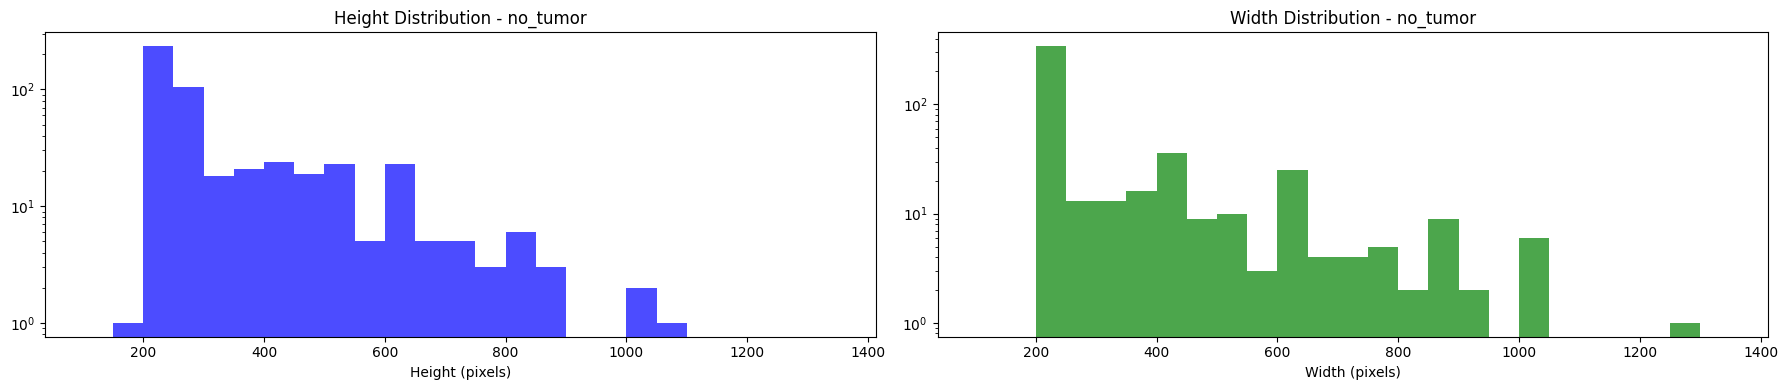

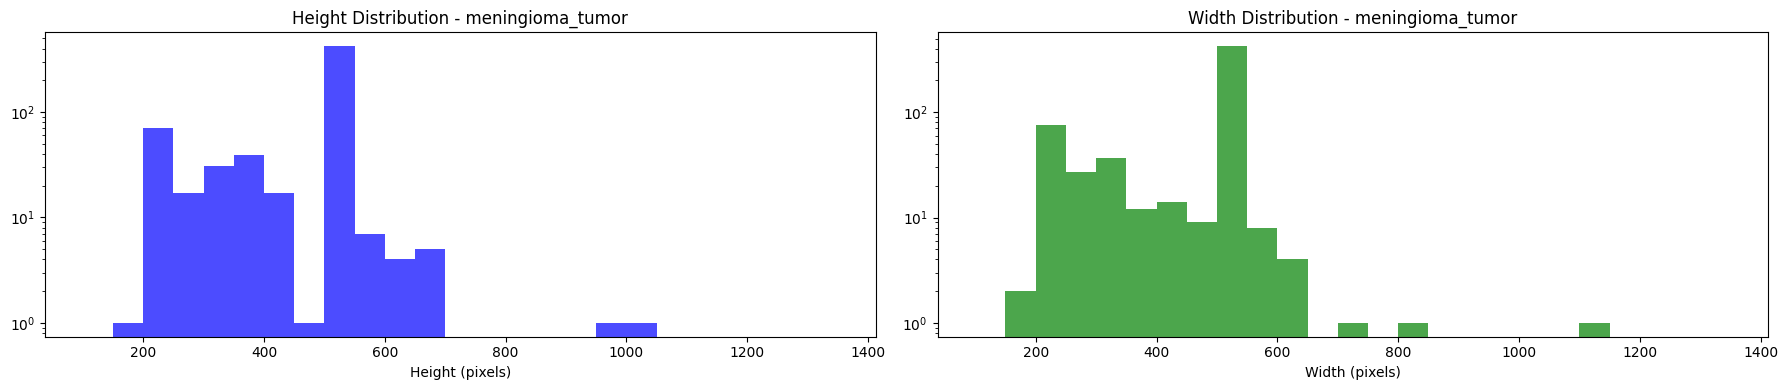

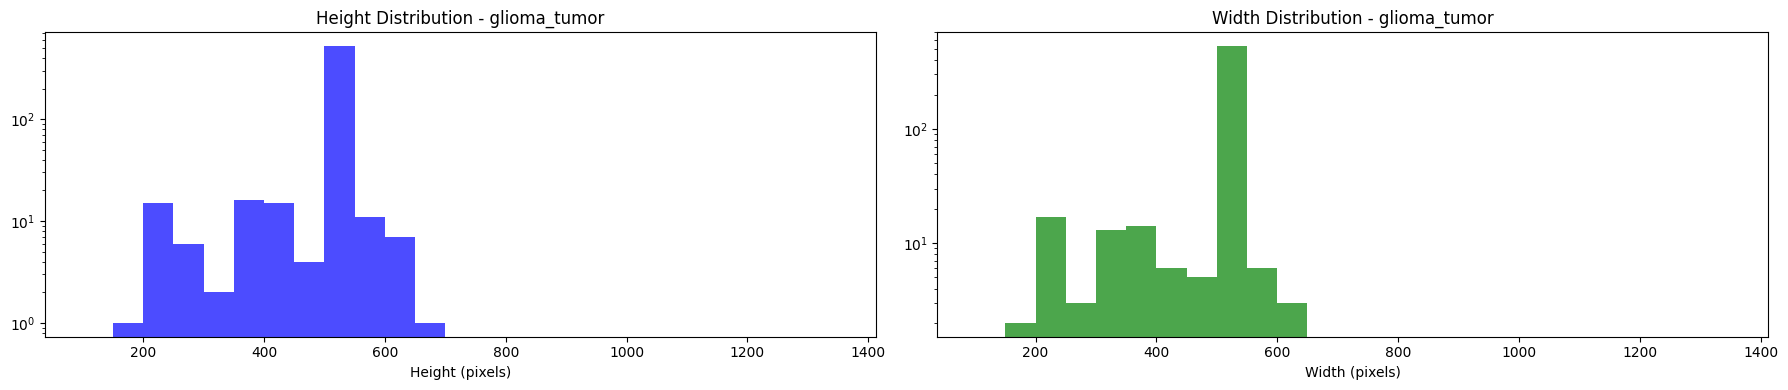

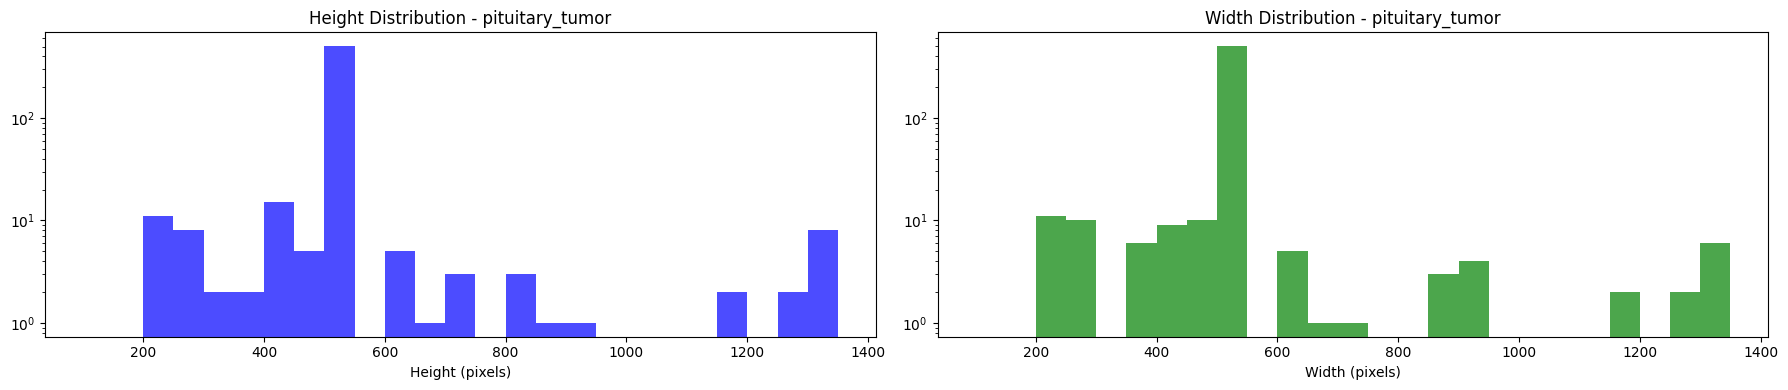

In [8]:
# show distribution of image size per class

class_stats = df_dimensions.groupby('Class').agg({
    'Height': ['min', 'max', 'mean'],
    'Width': ['min', 'max', 'mean'],
    'Channels': ['min', 'max', 'mean']
})

# get subset for a specific class
no_tumor_subset = df_dimensions[df_dimensions['Class'] == 'no_tumor']

# iterate through class subsets
for cls in classes:
    subset = df_dimensions[df_dimensions['Class'] == cls]

    # plot size distribution for this class
    plt.figure(figsize=(18, 4))
    plt.subplot(1, 2, 1)
    plt.hist(subset['Height'], bins=range(100,1400,50), alpha=0.7, color='blue')
    plt.title(f'Height Distribution - {cls}')
    plt.xlabel('Height (pixels)')
    plt.yscale('log')
    plt.subplot(1, 2, 2)
    plt.hist(subset['Width'], bins=range(100,1400,50), alpha=0.7, color='green')
    plt.title(f'Width Distribution - {cls}')
    plt.xlabel('Width (pixels)')
    plt.yscale('log')
    plt.tight_layout()
    plt.show()

## Channel Analysis

In [9]:
# Check if the channels are identical (pseudo-grayscale)

def check_grascale_channels():
    # generate a list of sample images from each class
    sample_images = []
    for cls in classes:
        class_dir = os.path.join("../data/brain_tumor_dataset/Training", cls)
        images = [file for file in os.listdir(class_dir) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
        sample_images.extend([os.path.join(class_dir, img) for img in images[:100]])  # take first few images from each class

    for img_path in sample_images:
        img = cv2.imread(img_path)

        if img is not None and img.shape[2] == 3:  # ensure image has 3 channels

            # separate the channels into arrays
            channel_1 = img[:, :, 0]
            channel_2 = img[:, :, 1]
            channel_3 = img[:, :, 2]
            
            # compare the channel arrays
            if np.array_equal(channel_1, channel_2) and np.array_equal(channel_1, channel_3):
                pass
                #print(f"Image {os.path.basename(img_path)} has identical channels (grayscale).")
            else:
                print(f"Image {os.path.basename(img_path)} has different channels (not grayscale).")
        else:
            print(f"Image {os.path.basename(img_path)} could not be processed.")

check_grascale_channels()


The code above goes through a a list of 100 images from each class and prints a message if the channels are not identical. Since there is no output, this indicates all images that were processed had identical channels.

## Pixel Intensities Analysis

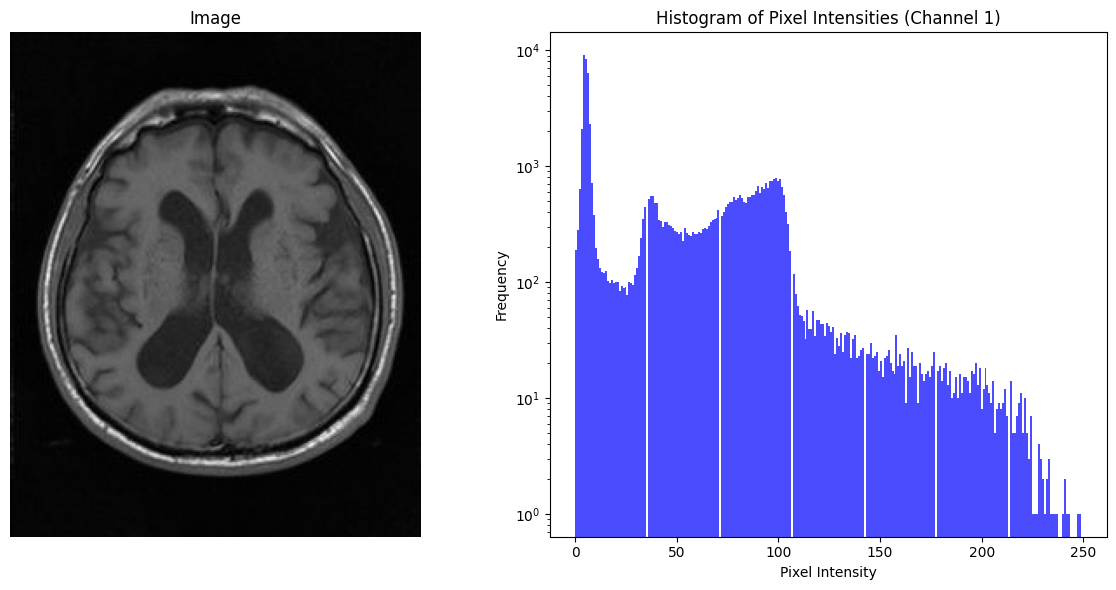

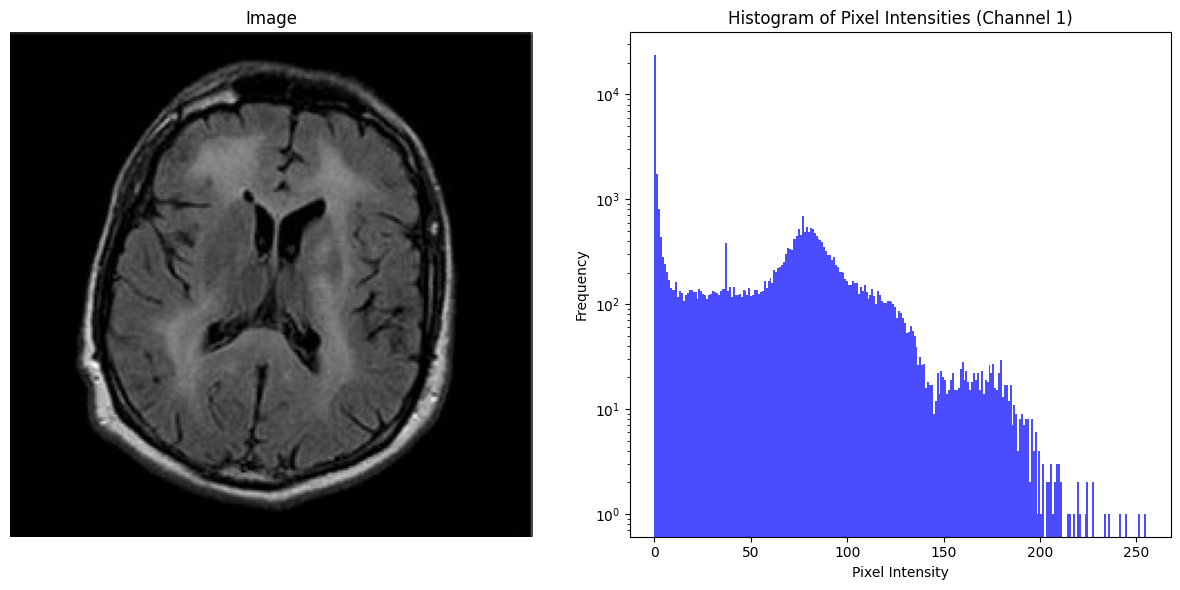

In [10]:
# Plot an image, and next to it plot a histogram of pixel intensities in the first channel

def plot_image_and_histogram(img_path):
    
    # split figure into two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # plot image in first subplot
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax1.imshow(img)
    ax1.set_title("Image")
    ax1.axis('off')

    # get first channel
    channel_1 = img[:, :, 0]

    # plot histogram of pixel intensities in second subplot
    ax2.hist(channel_1.ravel(), bins=256, color='blue', alpha=0.7)
    ax2.set_title("Histogram of Pixel Intensities (Channel 1)")
    ax2.set_xlabel("Pixel Intensity")
    ax2.set_ylabel("Frequency")
    plt.tight_layout()
    # set y axis to log scale
    ax2.set_yscale('log')


plot_image_and_histogram(os.path.join("../data/brain_tumor_dataset/Training/no_tumor/image(1).jpg"))
plot_image_and_histogram(os.path.join("../data/brain_tumor_dataset/Training/no_tumor/image(2).jpg"))

The histogram for image one shows sighs of discretization. I was curious if this was true for all images, so I just repeated the same analysis for image 2, which is not discretized. I suppose this could be a result of some processing step that was applied to a subset of the data. This seems feasible considering these images are likely amassed from different hospitals and hence are produced and processed with different hardware/software/etc.

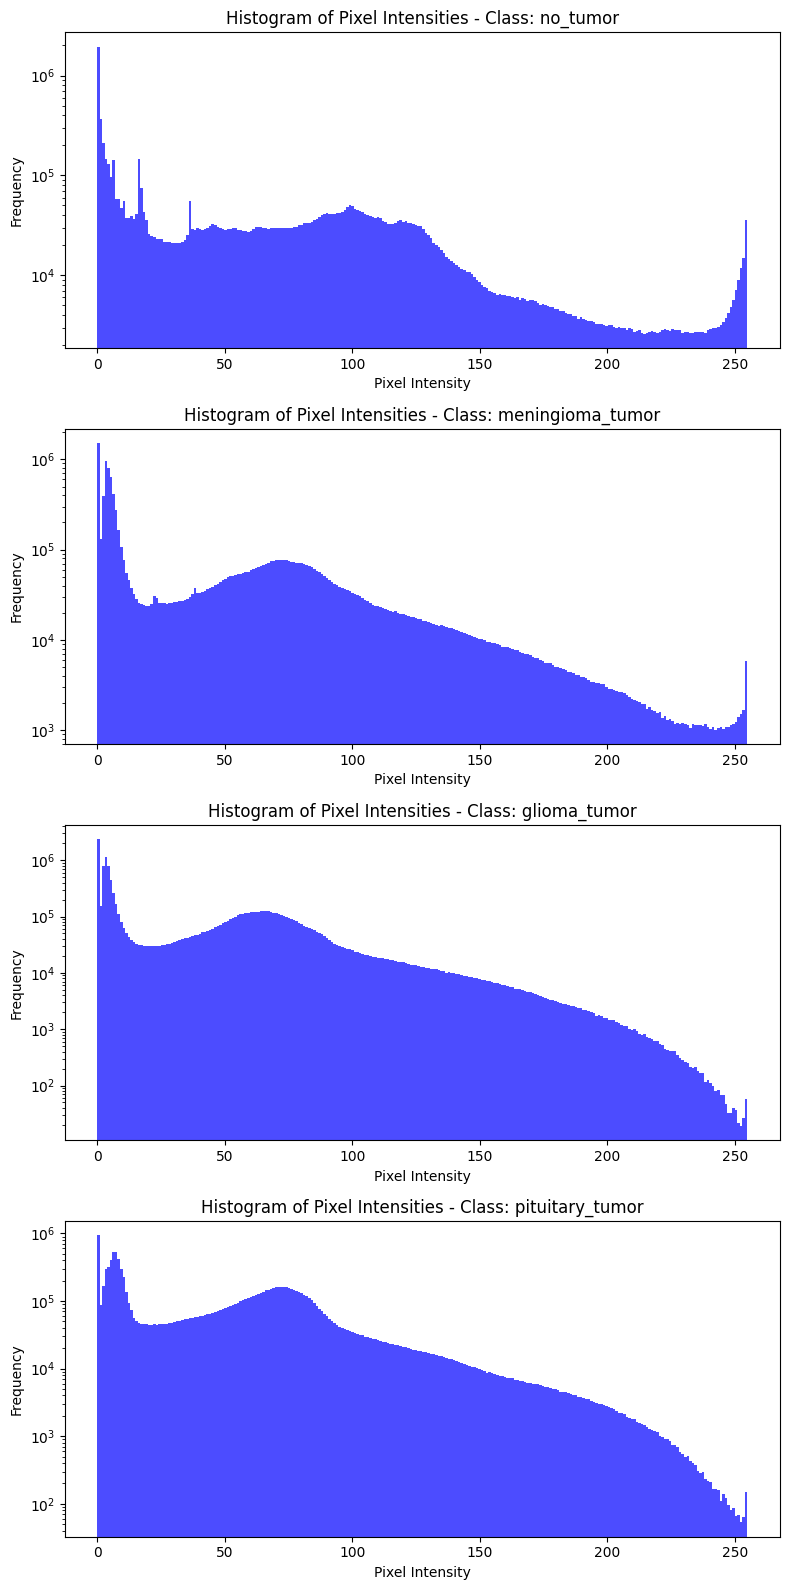

In [11]:
# Plot pixel intensity histogram for each class
def plot_histograms_per_class():
    fig, axes = plt.subplots(len(classes), 1, figsize=(8, 4 * len(classes)))
    
    for i, cls in enumerate(classes):
        class_dir = os.path.join("../data/brain_tumor_dataset/Training", cls)
        images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        # Sample 50 images per class to avoid overloading
        sample_images = images[:50] if len(images) > 50 else images
        
        all_channel_1 = []
        
        for img_name in sample_images:
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                channel_1 = img[:, :, 0]
                all_channel_1.extend(channel_1.ravel())
        
        axes[i].hist(all_channel_1, bins=256, color='blue', alpha=0.7)
        axes[i].set_title(f"Histogram of Pixel Intensities - Class: {cls}")
        axes[i].set_xlabel("Pixel Intensity")
        axes[i].set_ylabel("Frequency")
        axes[i].set_yscale('log')
    
    plt.tight_layout()
    plt.show()

plot_histograms_per_class()

## Image Quality Assessment

The following code studies image quality through three metrics: Laplacian variance, standard deviation, and mean intensity. Each metric is described in more detail as follows.

#### Laplacian Variance

[This](https://medium.com/@sagardhungel/laplacian-and-its-use-in-blur-detection-fbac689f0f88) article gives a nice, intuitive understanding of how the Laplacian Variance is calculated. In the simplest of explanations, it basically looks for areas of rapid changes in the image--e.g. edges. If an image is blurry, it has softer edges, and would have a lower Laplacian Variance score. Based on the graph above, we see that the healthy brain category contains the sharpest images. 

#### Standard Deviation

Pixel brightness occurs on a scale between 0 - 255. The second graph shows a distribution of the standard deviation of brightnesses per image. Again, the healthy brain category has the highest standard deviation. This corresponds to a higher contrast. Images with lower contrast have pixel intensities that are more closely distributed. 

#### Mean Intensity

The third graph shows mean intensity, which means it's a measure of brightness. Unsurprisingly, the healthy brain category is again at the top here. 

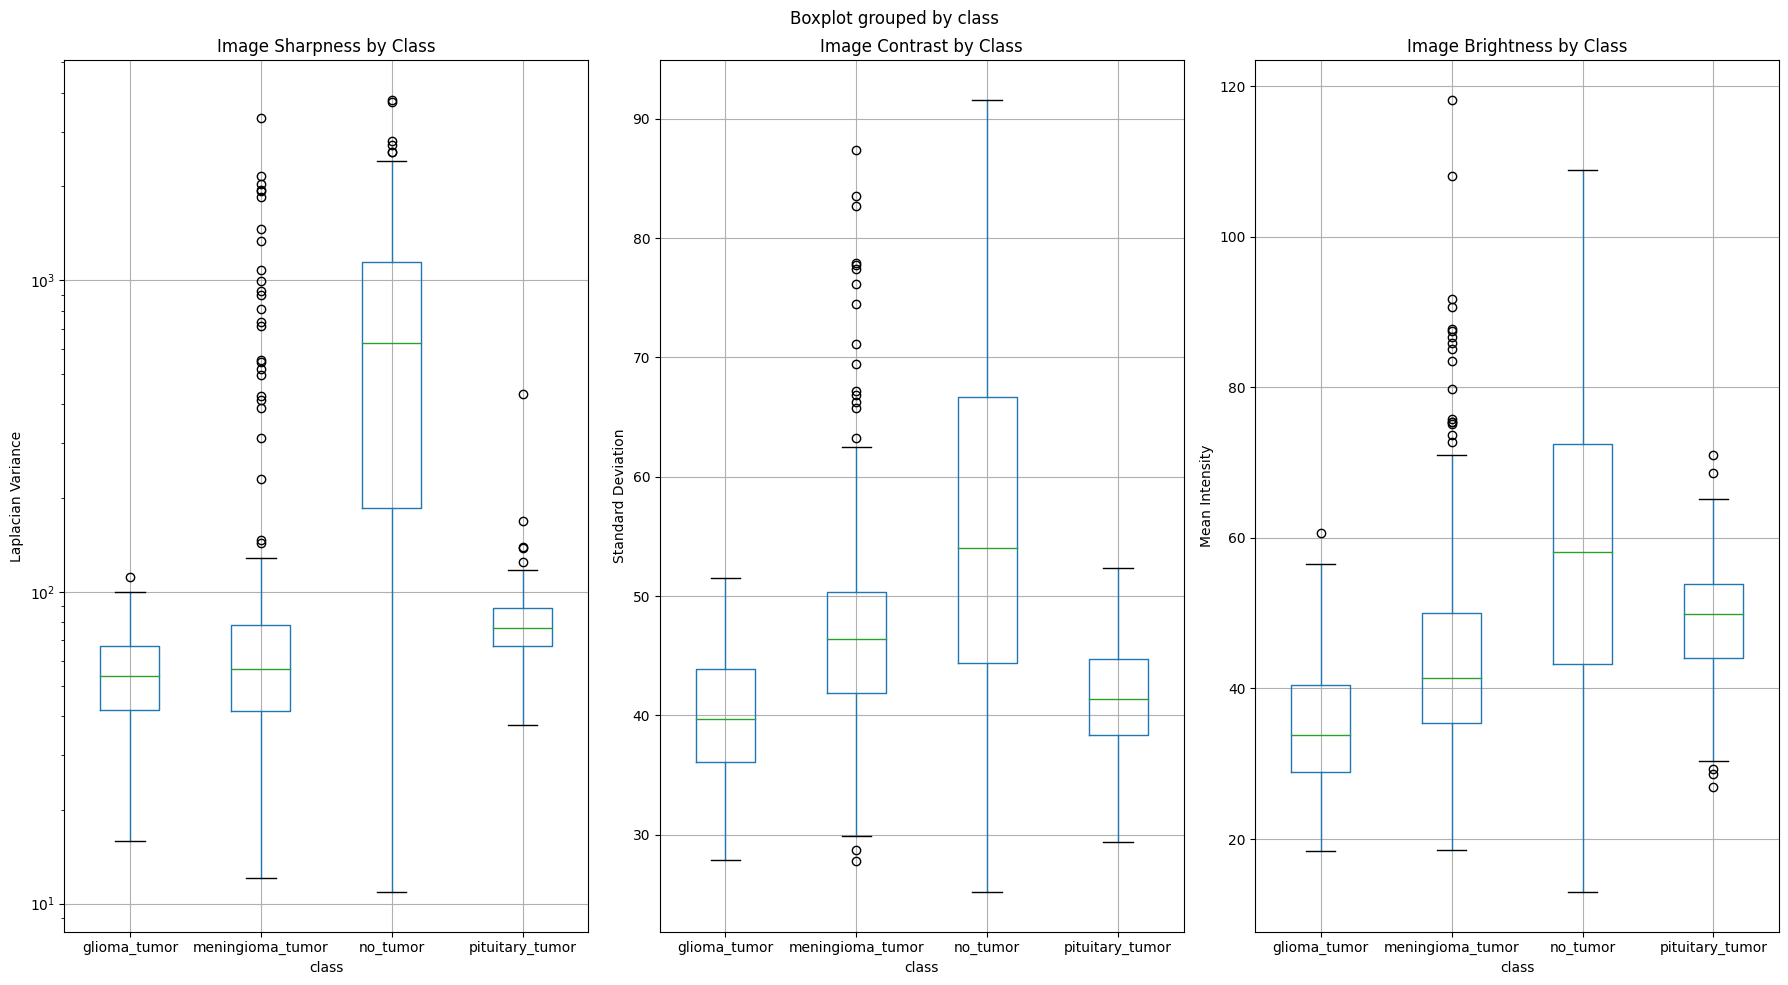

In [12]:
# Image Quality Assessment

def assess_image_quality():
    quality_metrics = [] # list to hold quality metrics (sharpness, contrast, brightness)
    
    for cls in classes:
        class_dir = os.path.join("../data/brain_tumor_dataset/Training", cls)
        images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        # Sample images per class
        sample_images = images[:200] if len(images) > 200 else images
        
        for img_name in sample_images:

            # read image 
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            if img is not None:
                # Calculate Laplacian variance (focus measure)
                laplacian_var = cv2.Laplacian(img, cv2.CV_64F).var()
                
                # Calculate contrast (std of pixel intensities)
                contrast = np.std(img)
                
                # Calculate brightness (mean of pixel intensities)
                brightness = np.mean(img)
                
                # append metrics to list per class
                quality_metrics.append({
                    'class': cls,
                    'image': img_name,
                    'sharpness': laplacian_var,
                    'contrast': contrast,
                    'brightness': brightness
                })
    
    df_quality = pd.DataFrame(quality_metrics)
    
    # Plot quality metrics
    fig, axes = plt.subplots(1, 3, figsize=(18, 10))
    
    df_quality.boxplot(column='sharpness', by='class', ax=axes[0])
    axes[0].set_title('Image Sharpness by Class')
    axes[0].set_ylabel('Laplacian Variance')
    axes[0].set_yscale('log')
    
    df_quality.boxplot(column='contrast', by='class', ax=axes[1])
    axes[1].set_title('Image Contrast by Class')
    axes[1].set_ylabel('Standard Deviation')
    
    df_quality.boxplot(column='brightness', by='class', ax=axes[2])
    axes[2].set_title('Image Brightness by Class')
    axes[2].set_ylabel('Mean Intensity')
    
    plt.tight_layout()
    plt.show()
    
    return df_quality

df_quality = assess_image_quality()

Also just to reiterate here, there was a new dataframe created above that holds the image filename, its sharpness, contrast, and brightness. 

In [13]:
df_quality.head()

class           image    sharpness   contrast  brightness
0  no_tumor  image(115).jpg   300.251555  30.561792   34.170991
1  no_tumor  image(142).jpg  1482.617867  77.695964   82.536951
2  no_tumor   image(49).jpg   694.544589  44.793985   36.750478
3  no_tumor    image(1).jpg   444.270898  42.965059   44.380304
4  no_tumor  image(284).jpg   224.172286  44.797464   37.318341

### Analysis of Orientation

I noticed above that images have different orientations--top/sides/front/back views. I wonder if there are certain orientations that are more common when diagnosing a specific type of cancer, and whether or not that could have an effect on the image quality features. It would be useful to be able to add a new column to df_quality called 'orientation' to describe this. Using [this](https://www.researchgate.net/figure/MRI-planes-for-MRI-head-scan-a-Axial-b-Coronal-c-Sagittal-MR-scanner-can-generate_fig2_338448026) as a quick reference, it seems that the best choices for this new column are:
- from top to down (axial plane)
- from front to back (coronal plane)
- and side to side (sagittal plane)


=== LABELING CLASS: no_tumor ===


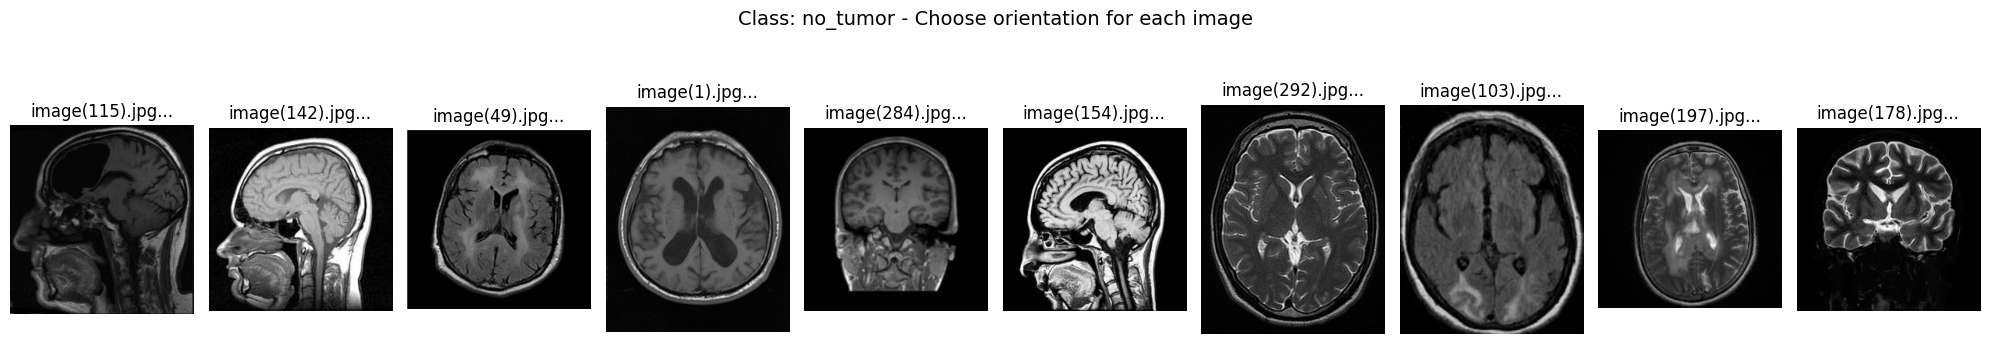

For each image above, enter orientation:
  A = Axial (top-down view)
  C = Coronal (front-back view)
  S = Sagittal (side view)
  U = Unknown/Unclear

=== LABELING CLASS: meningioma_tumor ===


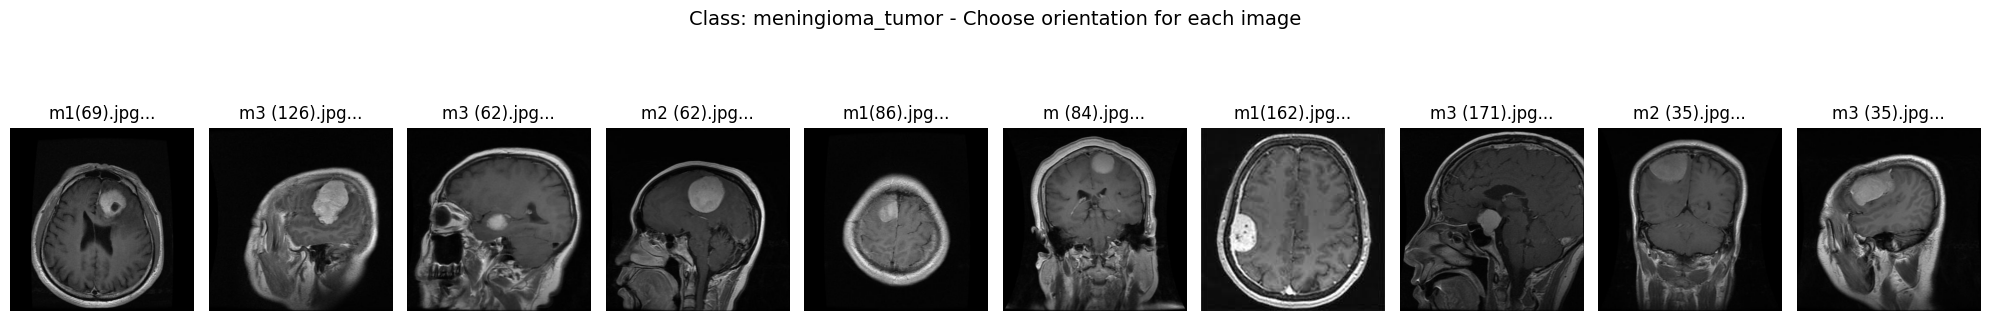

For each image above, enter orientation:
  A = Axial (top-down view)
  C = Coronal (front-back view)
  S = Sagittal (side view)
  U = Unknown/Unclear

=== LABELING CLASS: glioma_tumor ===


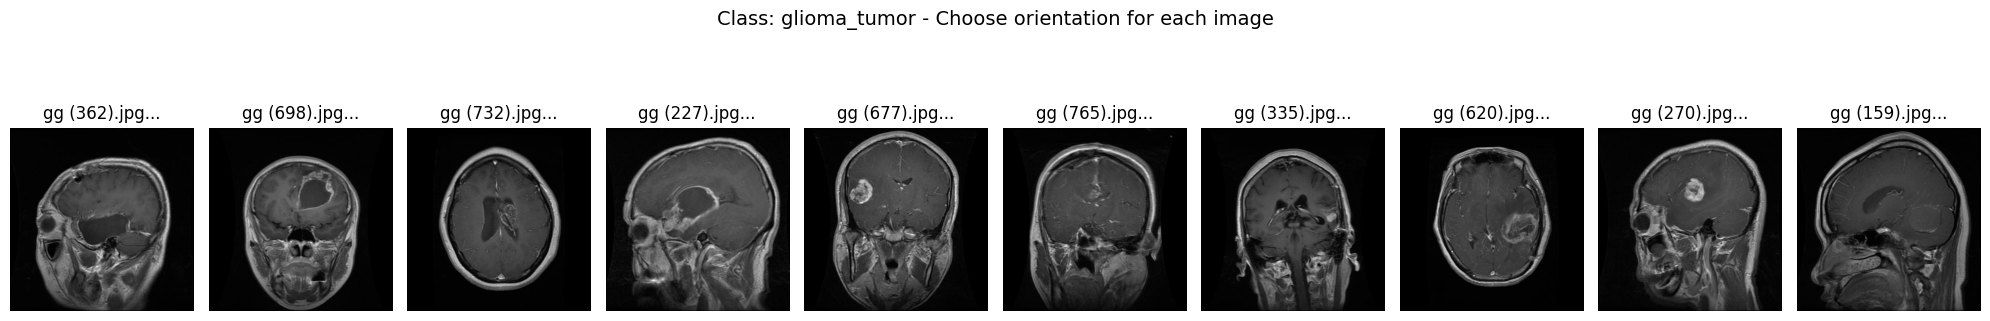

For each image above, enter orientation:
  A = Axial (top-down view)
  C = Coronal (front-back view)
  S = Sagittal (side view)
  U = Unknown/Unclear

=== LABELING CLASS: pituitary_tumor ===


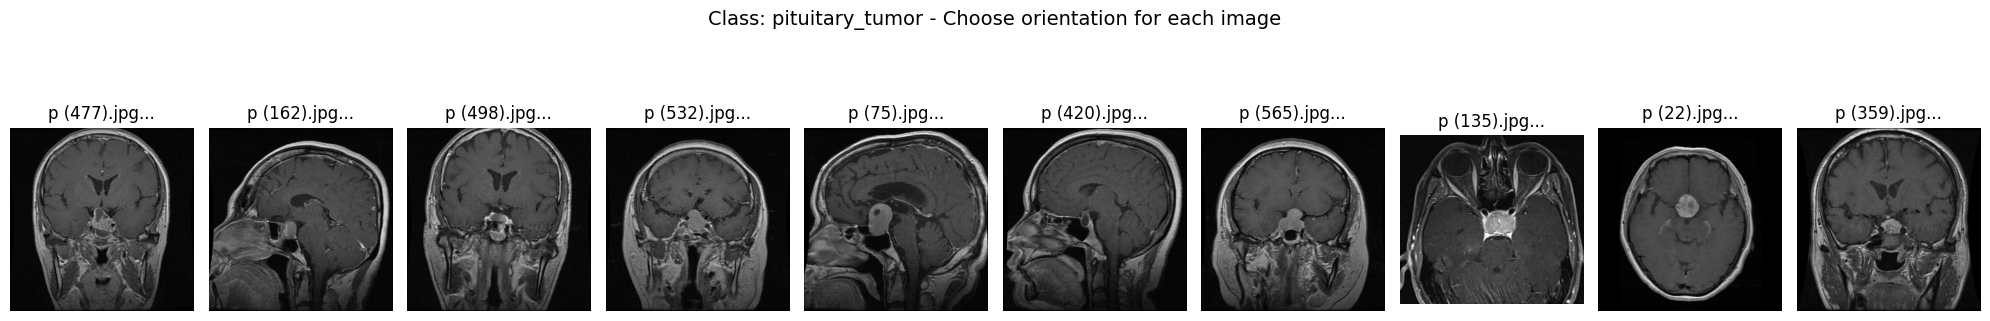

For each image above, enter orientation:
  A = Axial (top-down view)
  C = Coronal (front-back view)
  S = Sagittal (side view)
  U = Unknown/Unclear

Labeled 40 images:
               class           image orientation
0           no_tumor  image(115).jpg    sagittal
1           no_tumor  image(142).jpg    sagittal
2           no_tumor   image(49).jpg       axial
3           no_tumor    image(1).jpg       axial
4           no_tumor  image(284).jpg     coronal
5           no_tumor  image(154).jpg    sagittal
6           no_tumor  image(292).jpg       axial
7           no_tumor  image(103).jpg       axial
8           no_tumor  image(197).jpg       axial
9           no_tumor  image(178).jpg     coronal
10  meningioma_tumor      m1(69).jpg       axial
11  meningioma_tumor    m3 (126).jpg    sagittal
12  meningioma_tumor     m3 (62).jpg    sagittal
13  meningioma_tumor     m2 (62).jpg    sagittal
14  meningioma_tumor      m1(86).jpg       axial
15  meningioma_tumor      m (84).jpg     coron

In [14]:
def manual_orientation_labeling():
    """Display images for manual orientation labeling"""
    
    manual_labels = []
    
    for cls in classes:
        print(f"\n=== LABELING CLASS: {cls} ===")
        class_dir = os.path.join("../data/brain_tumor_dataset/Training", cls)
        images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        # Show first 10 images
        first_images = images[:10]
        
        # Display images in a grid
        fig, axes = plt.subplots(1, 10, figsize=(20, 4))
        
        for i, img_name in enumerate(first_images):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            axes[i].imshow(img)
            axes[i].set_title(f"{img_name[:15]}...")
            axes[i].axis('off')
        
        plt.suptitle(f'Class: {cls} - Choose orientation for each image', fontsize=14)
        plt.tight_layout()
        plt.show()
        
        # Get manual labels
        print("For each image above, enter orientation:")
        print("  A = Axial (top-down view)")
        print("  C = Coronal (front-back view)")  
        print("  S = Sagittal (side view)")
        print("  U = Unknown/Unclear")
        
        for i, img_name in enumerate(first_images):
            while True:
                label = input(f"Image {i+1} ({img_name[:20]}...): ").upper().strip()
                if label in ['A', 'C', 'S', 'U']:
                    orientation_map = {'A': 'axial', 'C': 'coronal', 'S': 'sagittal', 'U': 'unknown'}
                    manual_labels.append({
                        'class': cls,
                        'image': img_name,
                        'orientation': orientation_map[label]
                    })
                    break
                else:
                    print("Please enter A, C, S, or U")
    
    return manual_labels

# Run the manual labeling
manual_labels = manual_orientation_labeling()

# Convert to DataFrame
df_manual_labels = pd.DataFrame(manual_labels)
print(f"\nLabeled {len(df_manual_labels)} images:")
print(df_manual_labels)

In [15]:
# create new column in df_quality to hold orientation labels
df_quality['orientation'] = 'unknown'

# map manual labels to df_quality
for idx, row in df_manual_labels.iterrows():
    condition = (df_quality['class'] == row['class']) & (df_quality['image'] == row['image'])
    df_quality.loc[condition, 'orientation'] = row['orientation']

df_quality.head()

class           image    sharpness   contrast  brightness orientation
0  no_tumor  image(115).jpg   300.251555  30.561792   34.170991    sagittal
1  no_tumor  image(142).jpg  1482.617867  77.695964   82.536951    sagittal
2  no_tumor   image(49).jpg   694.544589  44.793985   36.750478       axial
3  no_tumor    image(1).jpg   444.270898  42.965059   44.380304       axial
4  no_tumor  image(284).jpg   224.172286  44.797464   37.318341     coronal

In [16]:
# Run image quality assessment again with only images labeled as 'axial'
def assess_quality_orientation(orientation_label):
    """Assess image quality for images with a specific orientation label.
    Inputs:
        orientation_label: str, one of 'axial', 'coronal', 'sagittal', 'unknown'
    Outputs:
        DataFrame with quality metrics for images with the specified orientation
    """
    quality_metrics = [] # list to hold quality metrics (sharpness, contrast, brightness)
    
    for cls in classes:
        class_dir = os.path.join("../data/brain_tumor_dataset/Training", cls)
        images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        # Sample images per class
        sample_images = images[:200] if len(images) > 200 else images
        
        for img_name in sample_images:

            # read image 
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            if img is not None:
                # Check if this image has the desired orientation label
                label_row = df_manual_labels[(df_manual_labels['class'] == cls) & (df_manual_labels['image'] == img_name)]
                if not label_row.empty and label_row.iloc[0]['orientation'] == orientation_label:
                    # Calculate Laplacian variance (focus measure)
                    laplacian_var = cv2.Laplacian(img, cv2.CV_64F).var()
                    
                    # Calculate contrast (std of pixel intensities)
                    contrast = np.std(img)
                    
                    # Calculate brightness (mean of pixel intensities)
                    brightness = np.mean(img)
                    
                    # append metrics to list per class
                    quality_metrics.append({
                        'class': cls,
                        'image': img_name,
                        'sharpness': laplacian_var,
                        'contrast': contrast,
                        'brightness': brightness
                    })
    
    df_quality_orientation = pd.DataFrame(quality_metrics)
    
    return df_quality_orientation

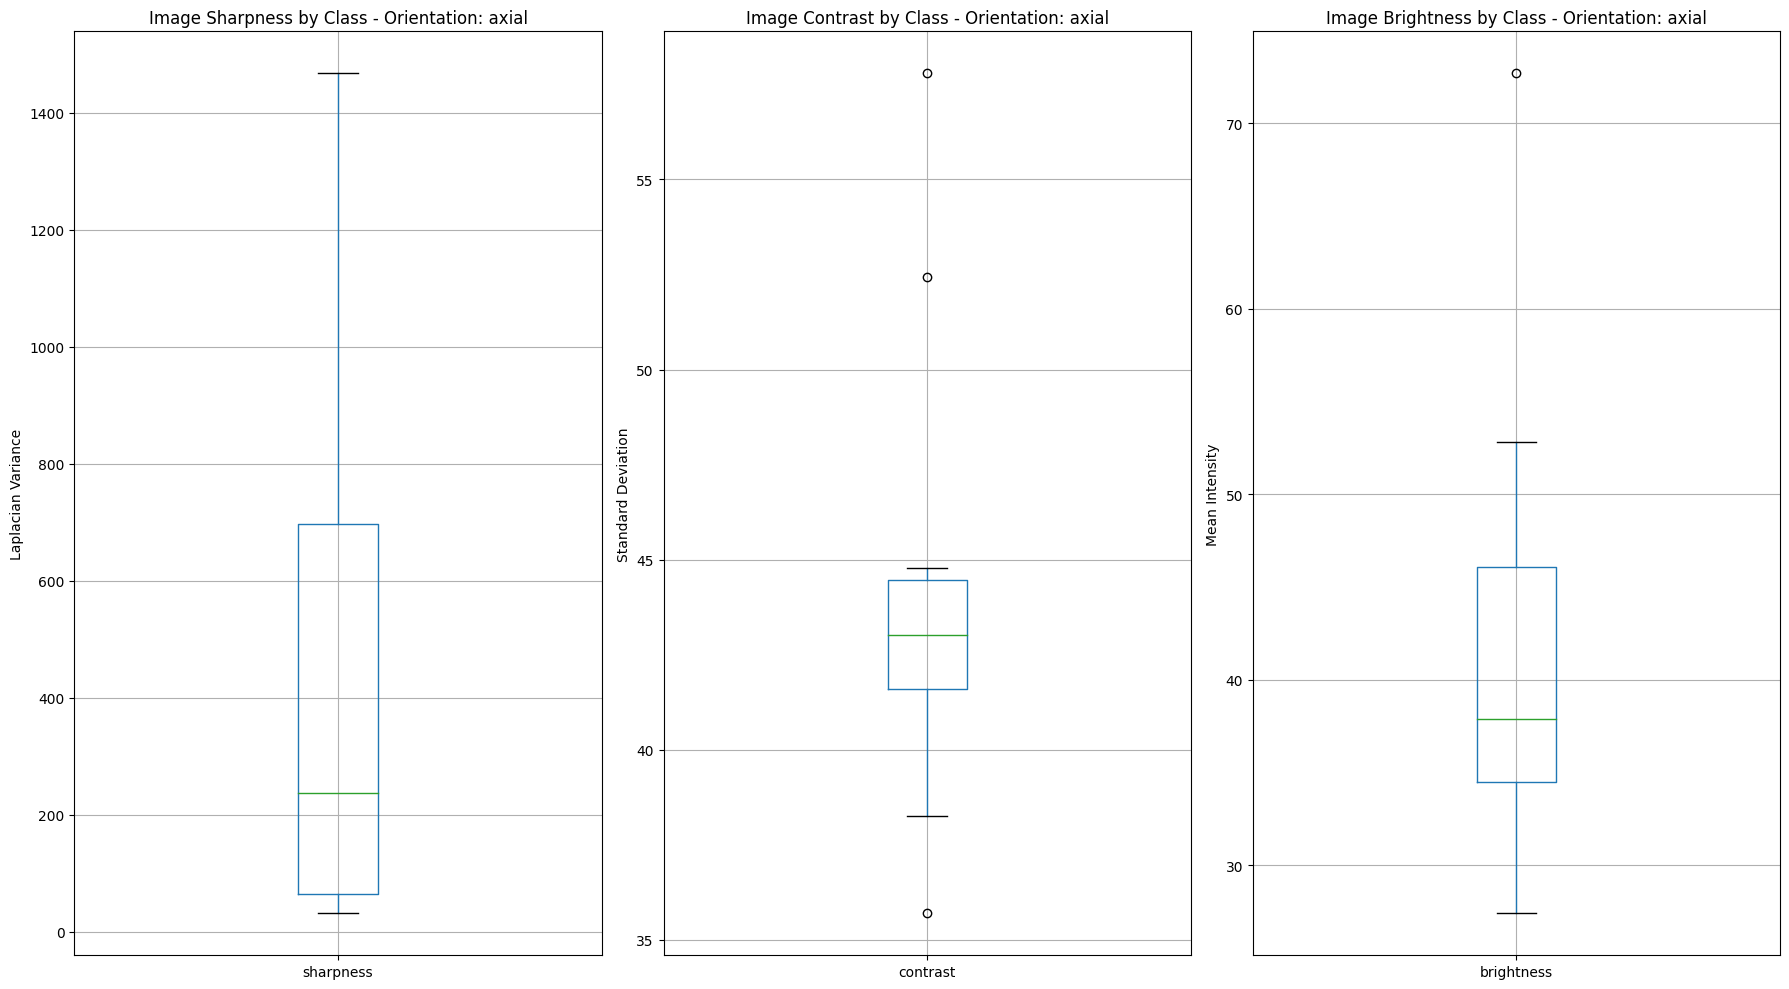

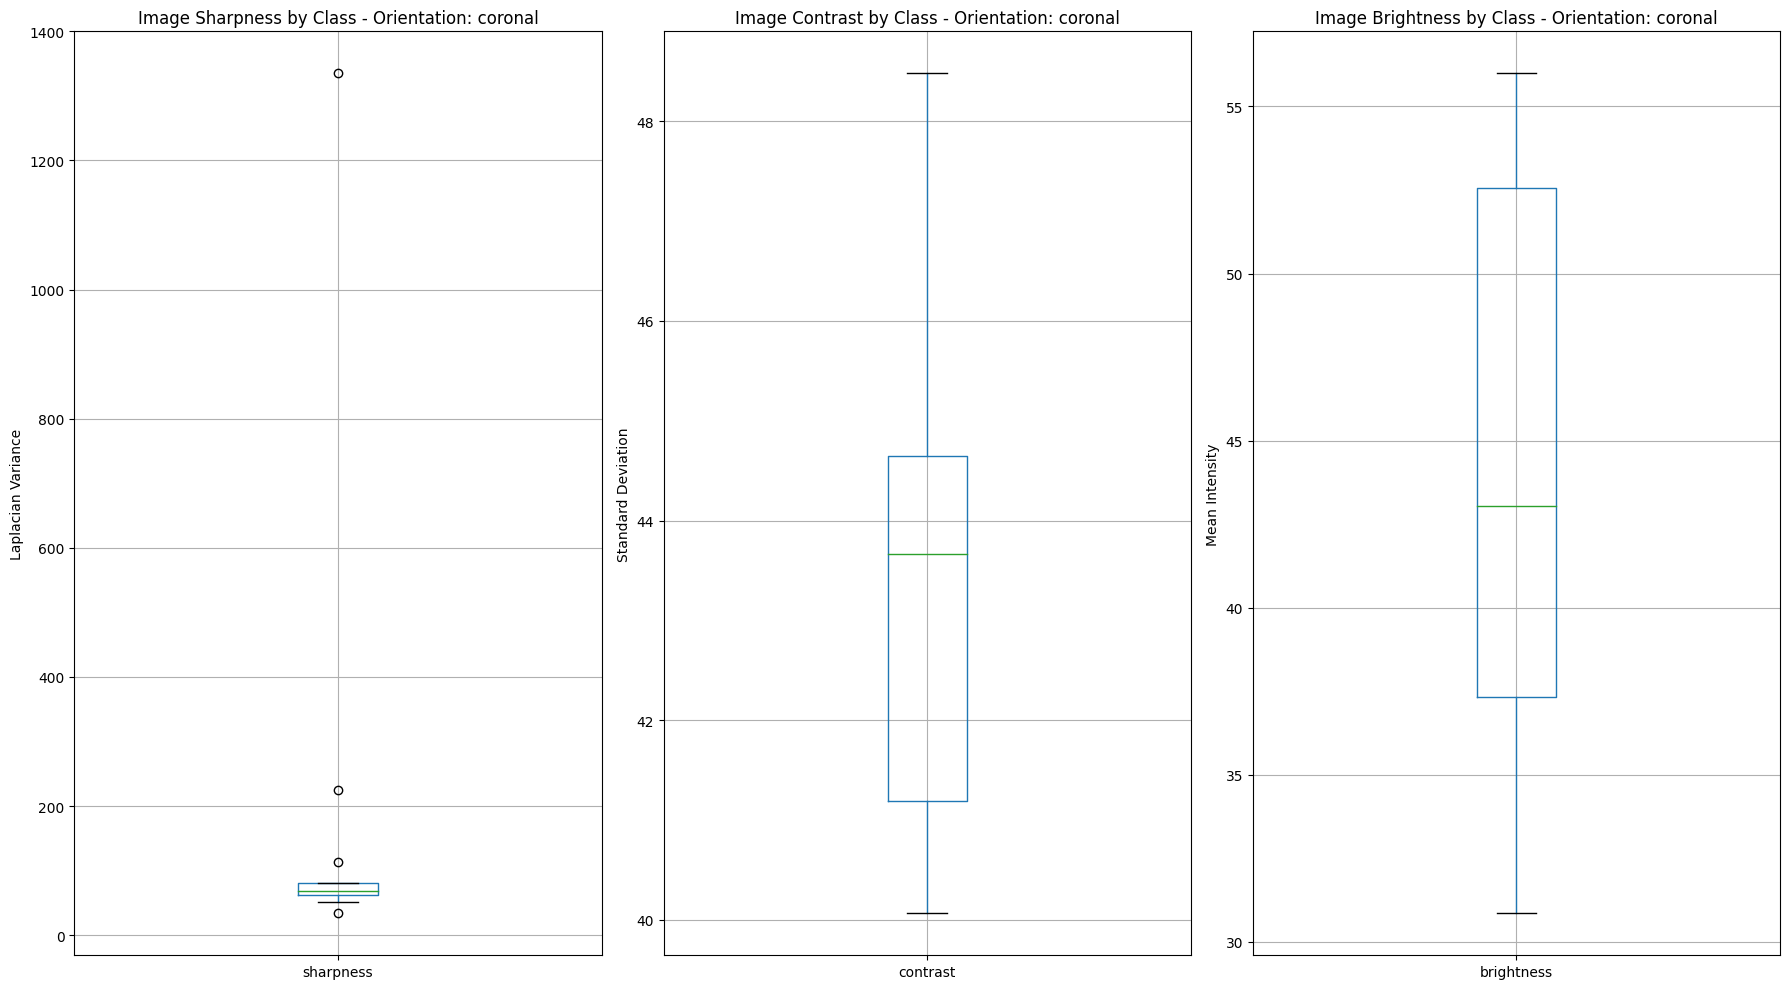

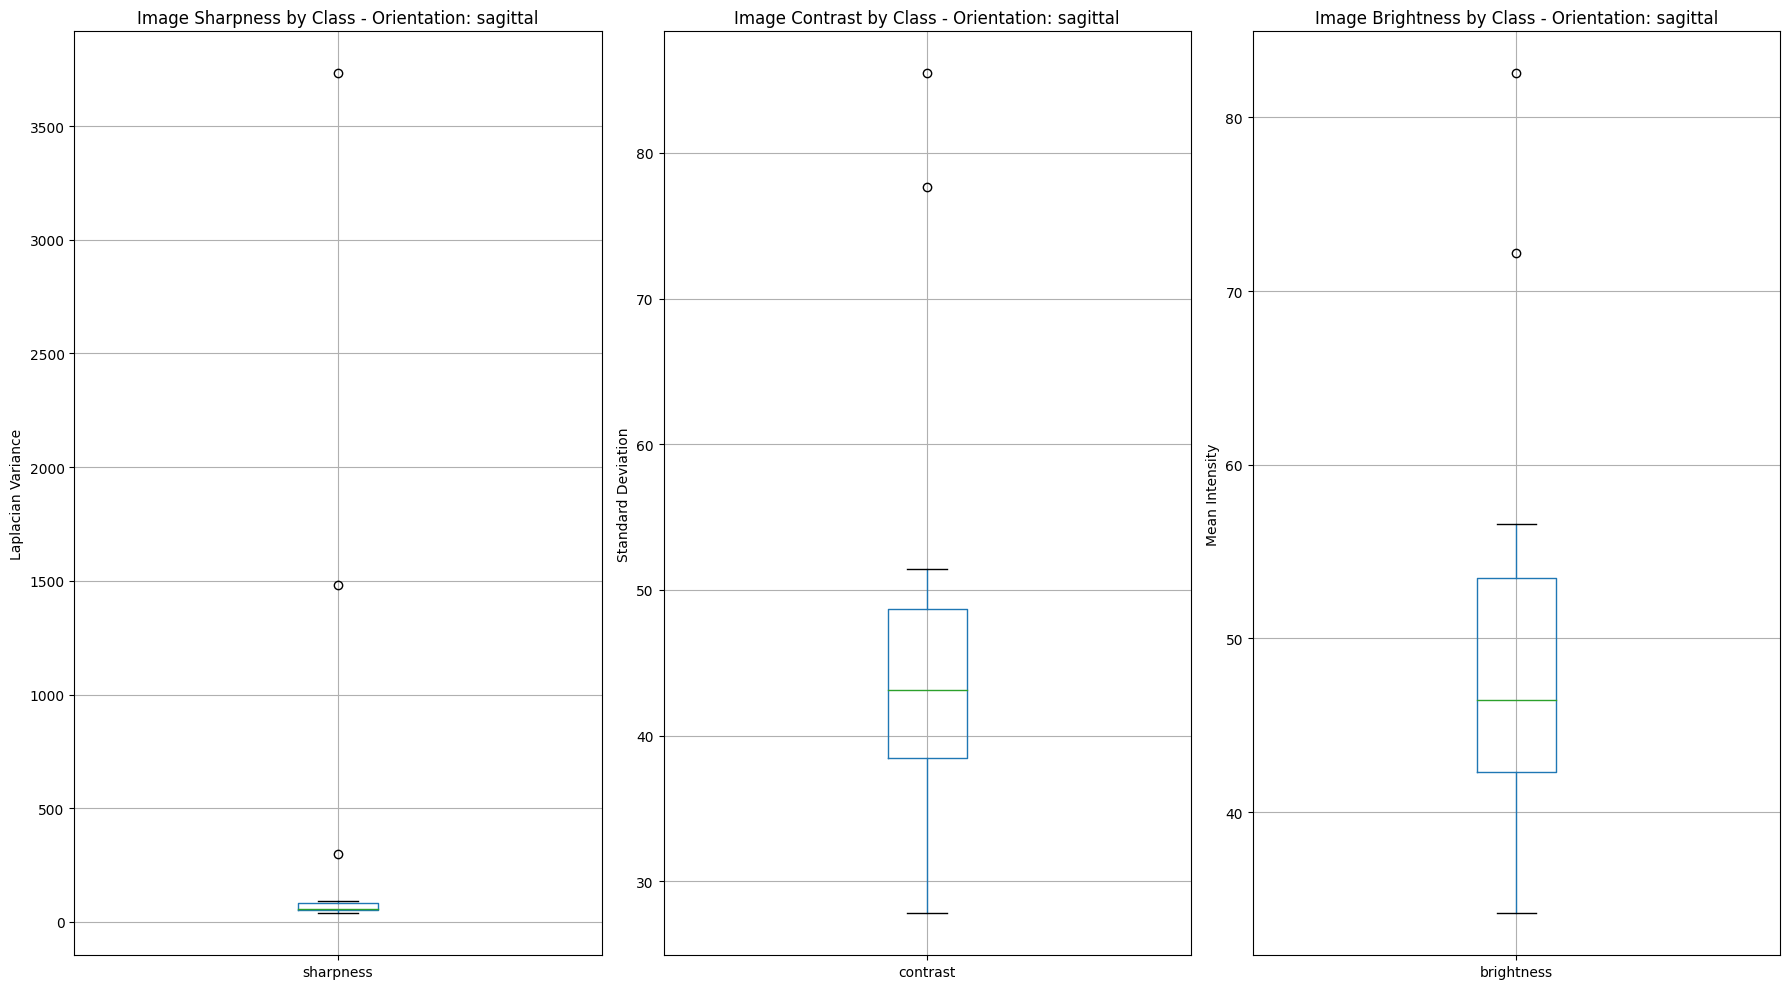

In [17]:
for orientation in ['axial', 'coronal', 'sagittal']:

    df_orient_quality = assess_quality_orientation(orientation)

    # plot quality metrics per orientation
    fig, axes = plt.subplots(1, 3, figsize=(18, 10))

    df_orient_quality.boxplot(column='sharpness', ax=axes[0])
    axes[0].set_title(f'Image Sharpness by Class - Orientation: {orientation}')
    axes[0].set_ylabel('Laplacian Variance')
    
    df_orient_quality.boxplot(column='contrast', ax=axes[1])
    axes[1].set_title(f'Image Contrast by Class - Orientation: {orientation}')
    axes[1].set_ylabel('Standard Deviation')
    
    df_orient_quality.boxplot(column='brightness', ax=axes[2])
    axes[2].set_title(f'Image Brightness by Class - Orientation: {orientation}')
    axes[2].set_ylabel('Mean Intensity')
    
    plt.tight_layout()
    plt.show()

In [18]:
# Summary Statistics
print("=== DATASET SUMMARY ===")
print(f"Total classes: {len(classes)}")
print(f"Class names: {classes}")

total_train = df_stats[df_stats['Dataset'] == 'Training']['Count'].sum()
total_test = df_stats[df_stats['Dataset'] == 'Testing']['Count'].sum()
print(f"Total training images: {total_train}")
print(f"Total testing images: {total_test}")
print(f"Total images: {total_train + total_test}")

print("\n=== CLASS BALANCE ===")
train_balance = df_stats[df_stats['Dataset'] == 'Training']
for _, row in train_balance.iterrows():
    percentage = (row['Count'] / total_train) * 100
    print(f"{row['Class']}: {row['Count']} images ({percentage:.1f}%)")

print(f"\n=== IMAGE PROPERTIES ===")
if 'df_dimensions' in locals():
    print(f"Common image size: {df_dimensions['Height'].mode().iloc[0]}x{df_dimensions['Width'].mode().iloc[0]}")
    print(f"Size variation: Height ({df_dimensions['Height'].min()}-{df_dimensions['Height'].max()}), Width ({df_dimensions['Width'].min()}-{df_dimensions['Width'].max()})")

if 'df_quality' in locals().keys():
    print(f"\n=== QUALITY METRICS ===")
    print(f"Average sharpness: {df_quality['sharpness'].mean():.2f}")
    print(f"Average contrast: {df_quality['contrast'].mean():.2f}")
    print(f"Average brightness: {df_quality['brightness'].mean():.2f}")

=== DATASET SUMMARY ===
Total classes: 4
Class names: ['no_tumor', 'meningioma_tumor', 'glioma_tumor', 'pituitary_tumor']
Total training images: 2870
Total testing images: 394
Total images: 3264

=== CLASS BALANCE ===
no_tumor: 395 images (13.8%)
meningioma_tumor: 822 images (28.6%)
glioma_tumor: 826 images (28.8%)
pituitary_tumor: 827 images (28.8%)

=== IMAGE PROPERTIES ===
Common image size: 512x512
Size variation: Height (167-1446), Width (174-1375)

=== QUALITY METRICS ===
Average sharpness: 272.35
Average contrast: 46.36
Average brightness: 47.29


### Correlation between Quality Metrics

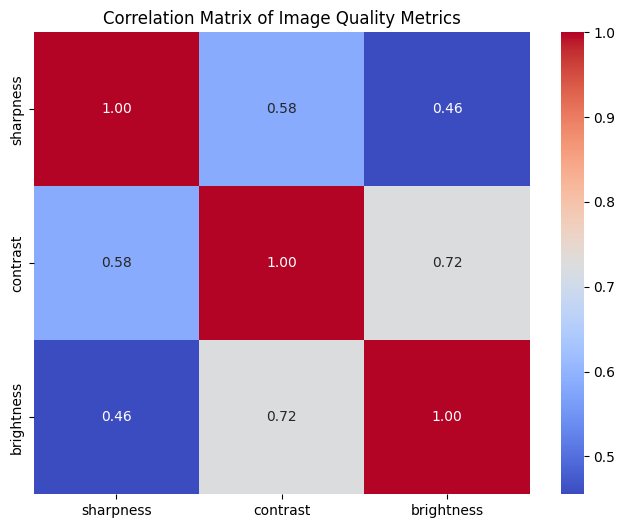

In [19]:
# Correlation analysis between quality metrics
correlation_matrix = df_quality[['sharpness', 'contrast', 'brightness']].corr()

# display correlation matrix
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Image Quality Metrics')
plt.show()

In [20]:
# find outliers according to each quality metric

df_quality['sharpness_z'] = (df_quality['sharpness'] - df_quality['sharpness'].mean()) / df_quality['sharpness'].std()
df_quality['contrast_z'] = (df_quality['contrast'] - df_quality['contrast'].mean()) / df_quality['contrast'].std()
df_quality['brightness_z'] = (df_quality['brightness'] - df_quality['brightness'].mean()) / df_quality['brightness'].std()

In [21]:
df_quality.head()

class           image    sharpness   contrast  brightness orientation  \
0  no_tumor  image(115).jpg   300.251555  30.561792   34.170991    sagittal   
1  no_tumor  image(142).jpg  1482.617867  77.695964   82.536951    sagittal   
2  no_tumor   image(49).jpg   694.544589  44.793985   36.750478       axial   
3  no_tumor    image(1).jpg   444.270898  42.965059   44.380304       axial   
4  no_tumor  image(284).jpg   224.172286  44.797464   37.318341     coronal   

   sharpness_z  contrast_z  brightness_z  
0     0.055496   -1.352999     -0.789545  
1     2.406914    2.683314      2.122087  
2     0.839642   -0.134232     -0.634260  
3     0.341913   -0.290851     -0.174944  
4    -0.095806   -0.133934     -0.600075

## Outlier Analysis

### Quality Metrics Z-Scores

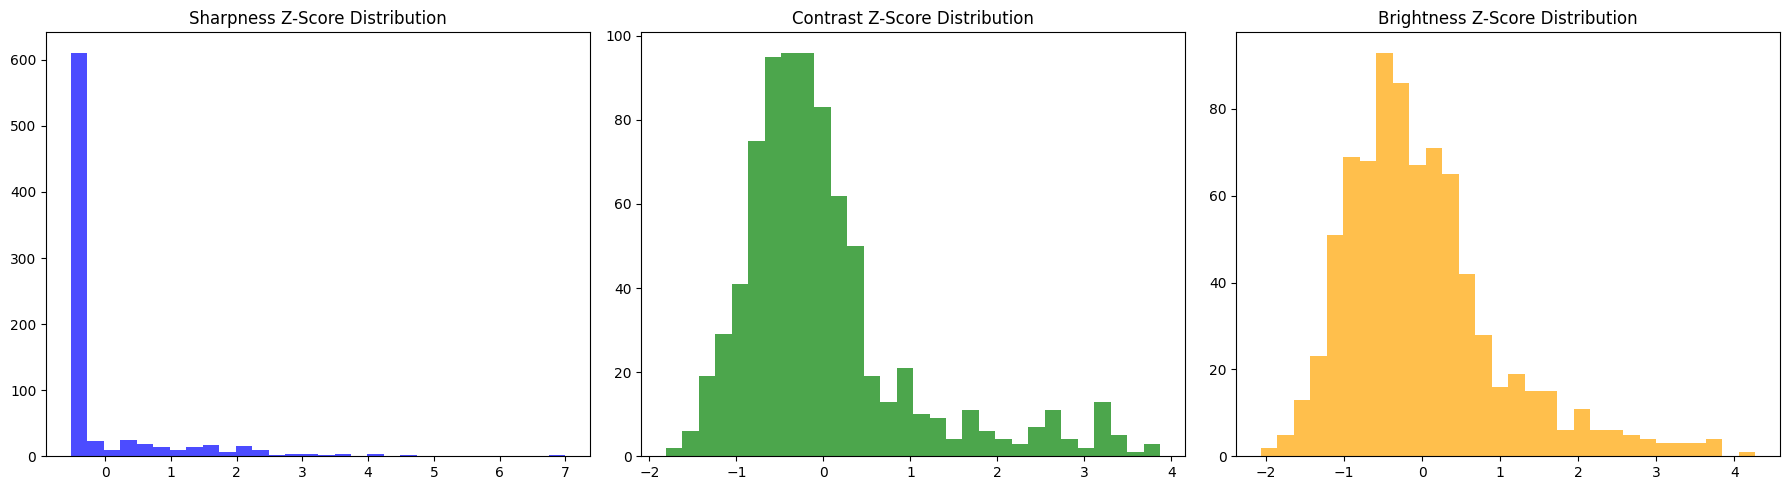

In [22]:
# distribution of z-scores
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].hist(df_quality['sharpness_z'], bins=30, color='blue', alpha=0.7)
axes[0].set_title('Sharpness Z-Score Distribution')
axes[1].hist(df_quality['contrast_z'], bins=30, color='green', alpha=0.7)
axes[1].set_title('Contrast Z-Score Distribution')
axes[2].hist(df_quality['brightness_z'], bins=30, color='orange', alpha=0.7)
axes[2].set_title('Brightness Z-Score Distribution')
plt.tight_layout()
plt.show()

In [23]:
# count outliers in each metric
outlier_threshold = 3  # z-score threshold for outliers
sharpness_outliers = df_quality[np.abs(df_quality['sharpness_z']) > outlier_threshold]
contrast_outliers = df_quality[np.abs(df_quality['contrast_z']) > outlier_threshold]
brightness_outliers = df_quality[np.abs(df_quality['brightness_z']) > outlier_threshold]

print(f"Sharpness outliers: {len(sharpness_outliers)}")
print(f"Contrast outliers: {len(contrast_outliers)}")
print(f"Brightness outliers: {len(brightness_outliers)}")

Sharpness outliers: 21
Contrast outliers: 24
Brightness outliers: 14


### Example Outlier Images


Sample Sharpness Outlier Images:


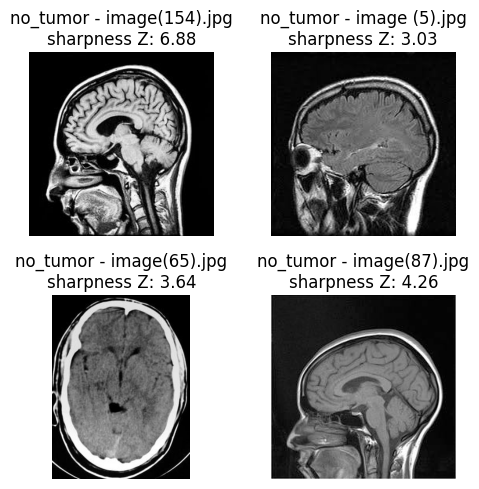


Sample Contrast Outlier Images:


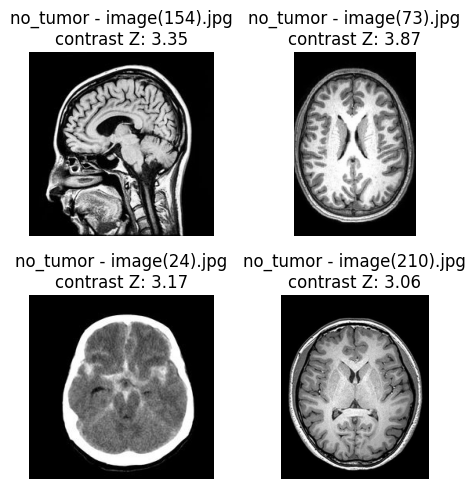


Sample Brightness Outlier Images:


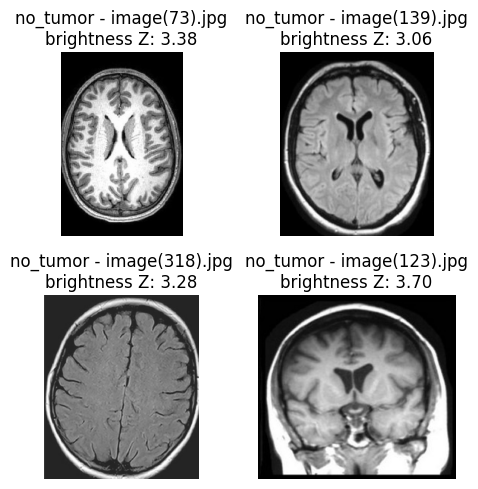

In [24]:
# display sample of outlier images for sharpness in a 2x2 grid

def display_outlier_images(outlier_df, metric_name):

    fig, axes = plt.subplots(2, 2, figsize=(5, 5))
    axes = axes.ravel()

    for i in range(min(4, len(outlier_df))):
        row = outlier_df.iloc[i]
        img_path = os.path.join("../data/brain_tumor_dataset/Training", row['class'], row['image'])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        axes[i].imshow(img)
        axes[i].set_title(f"{row['class']} - {row['image']}\n{metric_name} Z: {row[metric_name+'_z']:.2f}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

print("\nSample Sharpness Outlier Images:")
display_outlier_images(sharpness_outliers, 'sharpness')

print("\nSample Contrast Outlier Images:")
display_outlier_images(contrast_outliers, 'contrast')

print("\nSample Brightness Outlier Images:")
display_outlier_images(brightness_outliers, 'brightness')

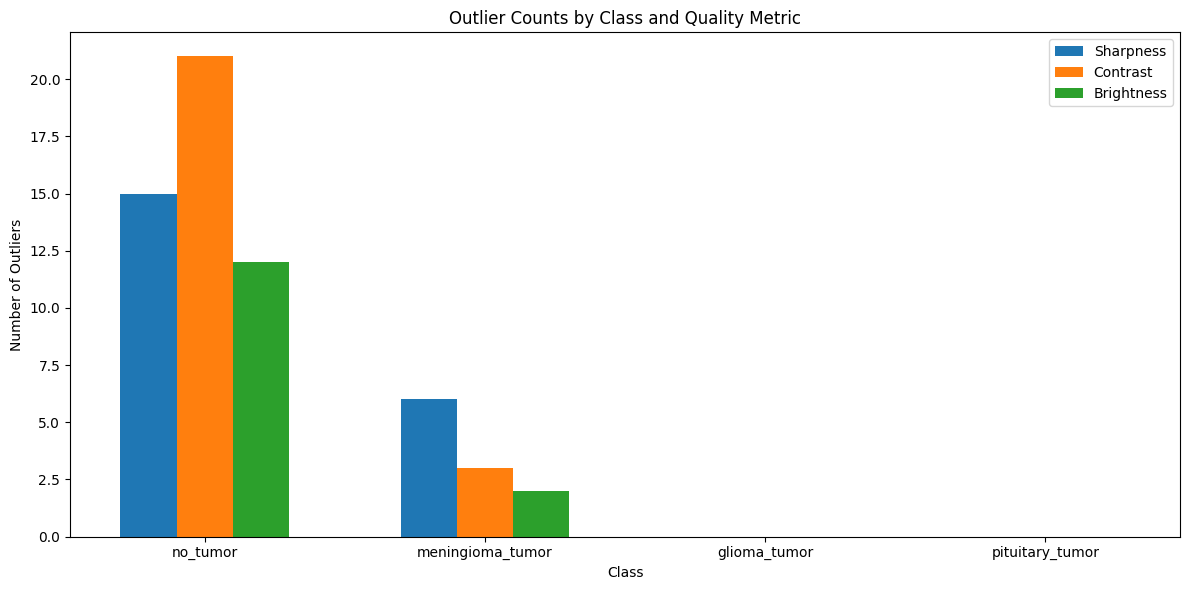

In [25]:
# show class distribution of outliers
# x-axis: metric names; each metric has a bar for each class showing number of outliers

outlier_counts = {
    'sharpness': sharpness_outliers['class'].value_counts(),
    'contrast': contrast_outliers['class'].value_counts(),
    'brightness': brightness_outliers['class'].value_counts()
    }

metrics = list(outlier_counts.keys())
classes_list = classes

x = np.arange(len(classes_list))  # the label locations
width = 0.2  # the width of the bars
fig, ax = plt.subplots(figsize=(12, 6))
for i, metric in enumerate(metrics):
    counts = [outlier_counts[metric].get(cls, 0) for cls in classes_list]
    ax.bar(x + i * width, counts, width, label=metric.capitalize())
ax.set_xlabel('Class')
ax.set_ylabel('Number of Outliers')
ax.set_title('Outlier Counts by Class and Quality Metric')
ax.set_xticks(x + width)
ax.set_xticklabels(classes_list)
ax.legend()
plt.tight_layout()
plt.show()

## Key Findings & Recommendations

In [26]:
# Add comprehensive data quality assessment
print("\n=== DATA QUALITY ASSESSMENT ===")
print(f"Total images assessed for quality: {len(df_quality)}")
extreme_outliers = len(df_quality[(abs(df_quality['sharpness_z']) > 3) | (abs(df_quality['contrast_z']) > 3)])
print(f"Images with extreme outliers: {extreme_outliers} ({(extreme_outliers / len(df_quality)) * 100:.2f}%)")
print(f"Very small images (<200px): {len(df_dimensions[(df_dimensions['Height'] < 200) | (df_dimensions['Width'] < 200)])}")
print(f"Very large images (>1000px): {len(df_dimensions[(df_dimensions['Height'] > 1000) | (df_dimensions['Width'] > 1000)])}")

# Recommend preprocessing steps based on findings
print("\n=== PREPROCESSING RECOMMENDATIONS ===")
print("1. Convert pseudo-RGB to grayscale")
print("2. Standardize image sizes (recommend 224x224 or 256x256)")
print("3. Consider removing extreme outliers")


=== DATA QUALITY ASSESSMENT ===
Total images assessed for quality: 800
Images with extreme outliers: 41 (5.12%)
Very small images (<200px): 6
Very large images (>1000px): 20

=== PREPROCESSING RECOMMENDATIONS ===
1. Convert pseudo-RGB to grayscale
2. Standardize image sizes (recommend 224x224 or 256x256)
3. Consider removing extreme outliers
